# Lab Six: CNNs

Team: Mike Wisniewski

In [1]:
import glob
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics as mt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from PIL import Image

## Dataset Selection

>Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

I have decided to choose the tumor dataset found here: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

I believe this dataset is a good dataset to use CNNs upon.  This dataset contains images of MRI scans in which a patient has a brain tumor or does not.  I believe this is an important problem to assist doctors in making correct choices while minimizing costly false positives and false negatives (more on this in the next section).  This dataset contains roughly 4000 images with a mix of tumors and normal MRI scans.

NOTE: These images come in a variety of resolution.  The lowest image resolution is 167 x 175.  While preprocessing these images, I choose to scale all images down to 150 x 150.  There is no particular reason for this resolution just that I believe each image should lose features as opposed to some images gaining features (which can cause errors).  Additionally, some images come in grayscale.  I use PIL to change these grayscale images to RGB to keep all consistent as well as keep the channels consistent with transfer learning models (in a later section).

In [2]:
# get a list of all picture paths
tumor = list(glob.glob('lab6_dataset/tumor/*'))
normal = list(glob.glob('lab6_dataset/normal/*'))

In [3]:
# create a dictionary that holds labels and paths for each image type
df_images = {
    'tumor' : tumor,
    'normal' : normal
}

Text(0.5, 1.0, 'normal')

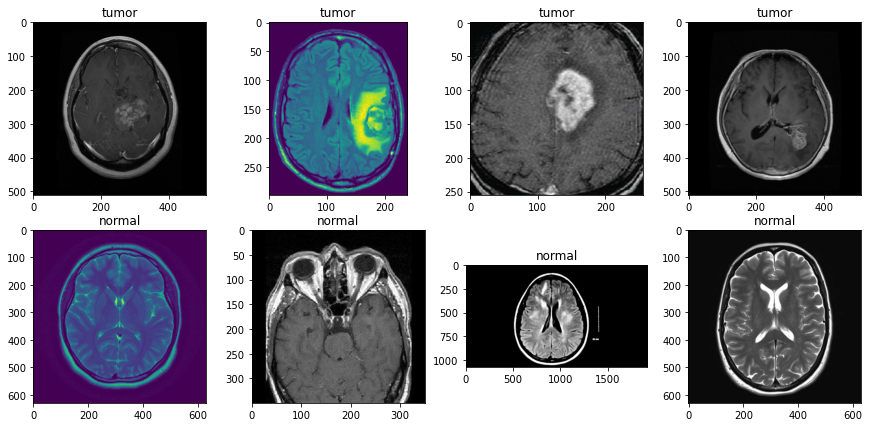

In [4]:
# plot out an image to see what it looks like
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
fig.set_size_inches(15, 7)

ax[0][0].imshow(img.imread(tumor[0]))
ax[0][1].imshow(img.imread(tumor[1]))
ax[0][2].imshow(img.imread(tumor[2]))
ax[0][3].imshow(img.imread(tumor[3]))
ax[1][0].imshow(img.imread(normal[0]))
ax[1][1].imshow(img.imread(normal[1]))
ax[1][2].imshow(img.imread(normal[2]))
ax[1][3].imshow(img.imread(normal[3]))
ax[0][0].set_title("tumor")
ax[0][1].set_title("tumor")
ax[0][2].set_title("tumor")
ax[0][3].set_title("tumor")
ax[1][0].set_title("normal")
ax[1][1].set_title("normal")
ax[1][2].set_title("normal")
ax[1][3].set_title("normal")

In [5]:
# preprocessing parameters
image_h = 150
image_w = 150
image_c = 3
image_size = (image_h, image_w, image_c)

In [6]:
# read in the datasets and labels
dataset, labels = [], []

for label, images in df_images.items():
    for image in images:
        
        # read in image as grayscale and resize image down to 150 x 150
        arr = Image.open(image).convert("RGB").resize((image_h, image_w))
        
        # normalize the image
        norm = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

        # append to dataset array
        dataset.append(np.array(norm))

        # extract labels
        labels.append(label)
        
dataset = np.array(dataset)
labels = np.array(labels)

Text(0.5, 1.0, 'normal')

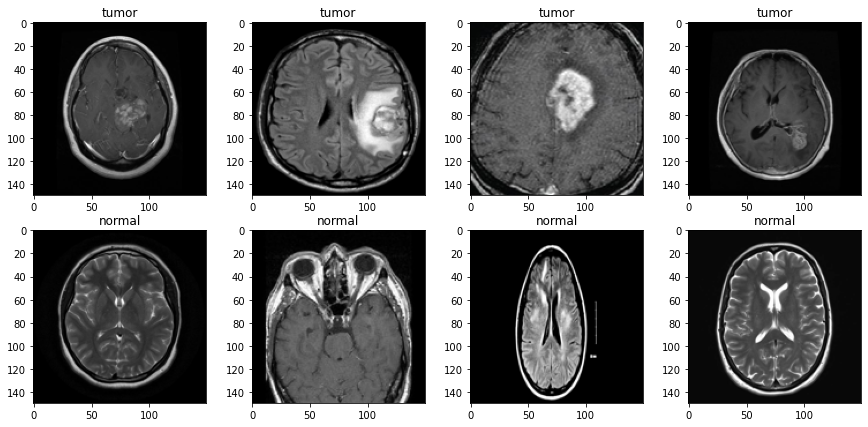

In [7]:
# plot out an image to see what it looks like
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(10,10))
fig.set_size_inches(15, 7)

ax[0][0].imshow(dataset[0])
ax[0][1].imshow(dataset[1])
ax[0][2].imshow(dataset[2])
ax[0][3].imshow(dataset[3])
ax[1][0].imshow(dataset[2513])
ax[1][1].imshow(dataset[2514])
ax[1][2].imshow(dataset[2515])
ax[1][3].imshow(dataset[2516])
ax[0][0].set_title("tumor")
ax[0][1].set_title("tumor")
ax[0][2].set_title("tumor")
ax[0][3].set_title("tumor")
ax[1][0].set_title("normal")
ax[1][1].set_title("normal")
ax[1][2].set_title("normal")
ax[1][3].set_title("normal")

In [8]:
# describe the dataset
shape_of_dataset = dataset.shape
n_samples = dataset.shape[0]
n_features = dataset.shape[1]**2
classes = np.unique(labels)
n_classes = len(classes)

print("The shape of our dataset:", f'{shape_of_dataset}')
print("The number of samples in our dataset:", f'{n_samples}')
print("The number of features in our dataset:", f'{n_features}')
print("The number of classes in our dataset:", f'{n_classes}')
print("The classes are:", f'{classes}')

The shape of our dataset: (4600, 150, 150, 3)
The number of samples in our dataset: 4600
The number of features in our dataset: 22500
The number of classes in our dataset: 2
The classes are: ['normal' 'tumor']


### Metrics

> [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

In order for this model to be successful, this model must have an exceptional F1 score (~100% accuracy).  Diagnosing cancer can not allow for false positives or false negatives to make it through.  A false positive will create a situation with a patient where the patient may undergo uneccessary medical procedures.  Doctor and hospital reputations will tarnish once the patient finds out that there is no cancer.  On the otherhand, we also want to limit false negatives because a missed diagnosis can kill patients.  Missed diagnoses can allow treatable and preventable cancers to spread and create a scenario where a patient dies prematurely because of missed diagnoses.  Therefore, F1 scores are most important for this model.

Our metrics of choice in order of importance for our model:

   - F1 Score
   - Precision
   - Accuracy
   - AUC
   - Binary Cross Entropy
   
Similar to lab 5, I have helper functions defined below to assist in extracting and plotting our important metrics.

In [9]:
# this is taken from lecture and repurposed for this exercise
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = net.predict(X_test)
    yhat[yhat<0.5] = 0 
    yhat[yhat>=0.5] = 1
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=np.unique(labels),yticklabels=np.unique(labels))
    plt.title(title_text+'{:.4f}'.format(acc))

In [10]:
def plot_cf_matrix(model, X_test, y_test):
    # predict y using the test dataset
    yhat_proba = model.predict(X_test)
    yhat = np.round(yhat_proba)

    # assess the precision and f1_scores
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))

In [11]:
def plot_metrics(scores):
    # plot out loss plus metrics
    plt.figure(figsize=(15,15))
    
    plt.subplot(5,2,1)
    plt.title('Training')
    for score in scores:
        plt.plot(score["binary_crossentropy"])
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend([1,2,3,4,5])
    
    plt.subplot(5,2,3)
    for score in scores:
        plt.plot(score["recall"])
    plt.ylabel('Recall')
    
    plt.subplot(5,2,5)
    for score in scores:
        plt.plot(score["precision"])
    plt.ylabel('Precision')
    
    plt.subplot(5,2,7)
    for score in scores:
        plt.plot(score["auc"])
    plt.ylabel('AUC')
    
    plt.subplot(5,2,9)
    for score in scores:
        plt.plot(score["Accuracy"])
    plt.ylabel('Accuracy')
    
    plt.subplot(5,2,2)
    plt.title('Validation')
    for score in scores:
        plt.plot(score["val_binary_crossentropy"])
        
    plt.subplot(5,2,4)
    for score in scores:
        plt.plot(score["val_recall"])

    plt.subplot(5,2,6)
    for score in scores:
        plt.plot(score["val_precision"])

    plt.subplot(5,2,8)
    for score in scores:
        plt.plot(score["val_auc"])
        
    plt.subplot(5,2,10)
    for score in scores:
        plt.plot(score["val_Accuracy"])
        
    model_ = 1
    avg_val_f1 = []
    for score in scores:
        model_precision = sum(score["val_precision"])/len(score["val_precision"])
        model_recall = sum(score["val_recall"])/len(score["val_recall"])
        model_f1 = 2*model_precision*model_recall/(model_precision + model_recall)
        print(f"Model {model_} Validation F1:", model_f1)
        avg_val_f1.append(model_f1)
        model_ += 1
        
    print(f"Average Model Validation F1 Score:", sum(avg_val_f1)/len(avg_val_f1))

In [12]:
def mcnemar_test(acc1, acc2):
    t = 2.26 / np.sqrt(10)  # 2.26 is looked up in a book for 95% CI
    e1 = 1-acc1
    e2 = 1-acc1
    e = e1 - e2
    stdtot = np.std(e)
    dbar = np.mean([e1, e2])

    print(dbar - t * stdtot, dbar + t * stdtot)
    return dbar - t * stdtot, dbar + t * stdtot

In [13]:
def avg_metric(scores, metric="precision"):
    # get the average precision for both the first DNN and the best NN
    metric_table = []
    for score in scores:
        if metric_table:
            metric_table = list(np.add(score[metric], metric_table))
        else:
            metric_table += score[metric]    
    metric_table = np.divide(metric_table,5)
    
    return metric_table

In [14]:
def roc_calc(model, X_test, y_test):
    yhat = model.predict(X_test)
    false_positive, true_positive, _ = mt.roc_curve(y_test.flatten(), yhat.flatten())
    roc = mt.auc(false_positive, true_positive)
    return false_positive, true_positive, roc

In [15]:
def f1_score_calc(precision, recall):
    return 2 * np.multiply(precision, recall)/np.add(precision, recall)

### Dataset Split

> [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

I have choosen to split my data into 5 sets during the training process.  On top of that, I also train test split using 80/20.  For the cross validation splits, 5 sets is an appropriate amount, and even as I type this I will argue that 5 may be too much.  In terms of total MRI scans (at hospital locations) per year, a rough estimation of 16-17 million happen every year (https://www.statista.com/statistics/820927/mri-scans-number-in-us-by-facility-type/).  This means that there are roughly 44,000 daily MRI scans.  Let's assume 20% of these scans are brain MRI scans.  This means that on a daily basis, 8,800 MRI scans are brain MRI scans.  Our model, if scaled properly and assuming all hospitals use it, can expect 8,800 brain MRI images daily.  Our total dataset size is roughly half of this, and each split is rouhgly ~10% of what we can expect our production model to process per day.  Therefore, I believe this is a safe split amounts to use.

I decided to also use a 20% test split because our dataset is between 1,000 and 10,000 records.  Not too many records to allow for >20% splits and not too few to allow for <20% splits.

I use a ShuffleSplit because I am basing this under the assumption that cancer is somewhat random.  Therefore, a random shuffle of the data as well as no stratification anywhere is appropriate to replicate a real life scenario.

In [16]:
# select cross validation
cv = ShuffleSplit(n_splits=5)

In [17]:
# shuffle the dataset as it was read in order of tumor and then normal
np.random.seed(42)
dataset, labels = shuffle(dataset, labels)

# encode y labels
encoder = LabelEncoder()
y_ohe = encoder.fit_transform(labels)

In [18]:
# split X and y into train, test
X_train, X_test, y_train, y_test = train_test_split(dataset, y_ohe, test_size=0.2, random_state=42)

### Data Augmentation

> [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

I decide to use a safe conservative approach to data augmentation, using the preset parameters from lecture.  The idea is to create some variability, but for the purpose of MRIs, there is no such thing (as of right now) to produce 3D images.  Almost all MRIs will always be in the same orientation.  But some variability may be appropriate.

In [19]:
# initialize Image Data Generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

# fit the data on train
datagen.fit(X_train)

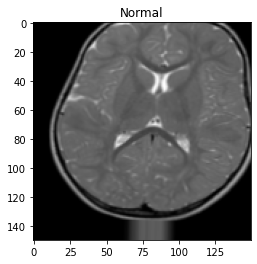

In [20]:
# print out an example of a generated image
tmps = datagen.flow(X_train, y_train, batch_size=1)

for tmp in tmps:
    plt.imshow(tmp[0].squeeze(),cmap='bone')
    if tmp[1][0] == 0:
        plt.title("Normal")
    else:
        plt.title("Tumor")
    break

### Modeling

> [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge.

For the models, we use an AdaM optimizer because I believe AdaM is the best optimizer to use for image recognition and is often used in exercises like this one.  For the loss function, binary cross entropy is most appropriate as this is a binary cross entropy problem.  We want to have our model view loss in the eyes of probability.  What is the probability that this MRI shows a tumor?  Binary cross entropy acting as the loss function achieves this.

For metrics, see above.  F1 Score is not an inherent metric captured in TensorFlow.  Therefore, it is important to get the components of F1 Score (Precision and Recall).

For weights, glorot uniform is used.  This is a safe weight initializer for our dense layers.

Each convolution layer will have a ReLu activation (ReLu is widely used in industry for image classification).  Some models will have different convolutional layer activation functions which will be specified in the model code.  For dense layers, I am always a big fan of tanh activation functions.  But my justification is because tanh is similar to sigmoid.  Because our model is viewing this classification from the perspective of probability, tanh synchronizes nicely with the final layer activation function of sigmoid (at least that's what I believe).

25 epochs are chosen because running anything more would be time costly.  Batch size of 64 is chosen for similar reasons.

For each model section, I will explain what's in the model (and any changes from prior models) at the beginning and perform analysis at the end.

In [21]:
# model parameters
optimizer = "adam"
loss = "binary_crossentropy"
metrics = ["Precision", "Recall", "Accuracy", "AUC", "binary_crossentropy"]
kernel_initializer = "glorot_uniform"
input_shape = image_size
conv_layer_activation = "relu"
dense_layer_activation = "tanh"
final_activation = "sigmoid"
epochs = 25
batch_size = 64

### Base Model (MLP)

This model is to create a baseline MLP model with 3 dense layers.  Each layer decreases in number of neurons while also incorporating dropout.

In [22]:
def base_model(input_shape):
    
    # initialize a convolutional neural network
    mlp = Sequential()

    # flatten input image
    mlp.add(Flatten())
    
    # add first dense layer
    mlp.add(Dense(input_dim=input_dim, units=128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    mlp.add(Dropout(0.2))
    
    # add second dense layer
    mlp.add(Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    mlp.add(Dropout(0.2))
    
    # add third dense layer
    mlp.add(Dense(64, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add output layer
    mlp.add(Dense(1, activation=final_activation))

    # Let's train the model 
    mlp.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return mlp

In [23]:
# initialize empty list of scores
base_model_scores = []

cv_split = 1

# initialize model
input_dim = X_train.shape[1]**2
base_model = base_model(input_shape)

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    

    # fit the model
    base_model_history = base_model.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    base_model_scores.append(base_model_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


In [24]:
# summarize model
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

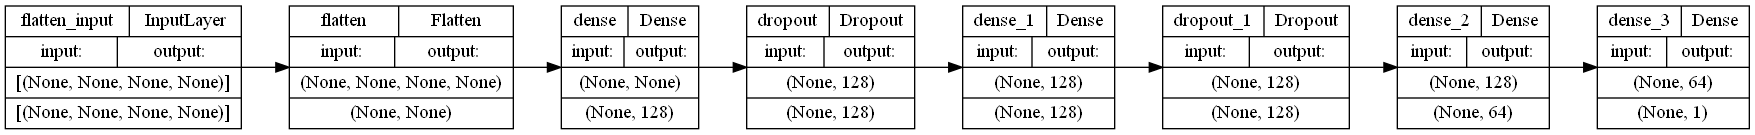

In [25]:
# plot model architecture
plot_model(
    base_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

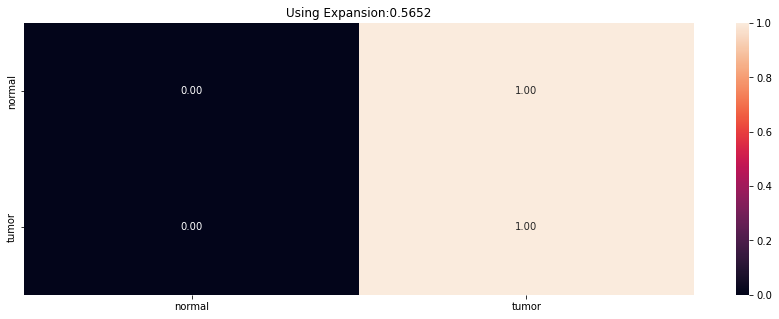

In [26]:
# summarize the last model to run
summarize_net(base_model, X_test, y_test, title_text='Using Expansion:')

In [27]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(base_model, X_test, y_test)

[[  0 400]
 [  0 520]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.57      1.00      0.72       520

    accuracy                           0.57       920
   macro avg       0.28      0.50      0.36       920
weighted avg       0.32      0.57      0.41       920



C:\Users\EV-04\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\EV-04\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\EV-04\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 1 Validation F1: 0.6685121203911584
Model 2 Validation F1: 0.695459294360387
Model 3 Validation F1: 0.6890592457203824
Model 4 Validation F1: 0.7019400396399522
Model 5 Validation F1: 0.6847552344578566
Average Model Validation F1 Score: 0.6879451869139472


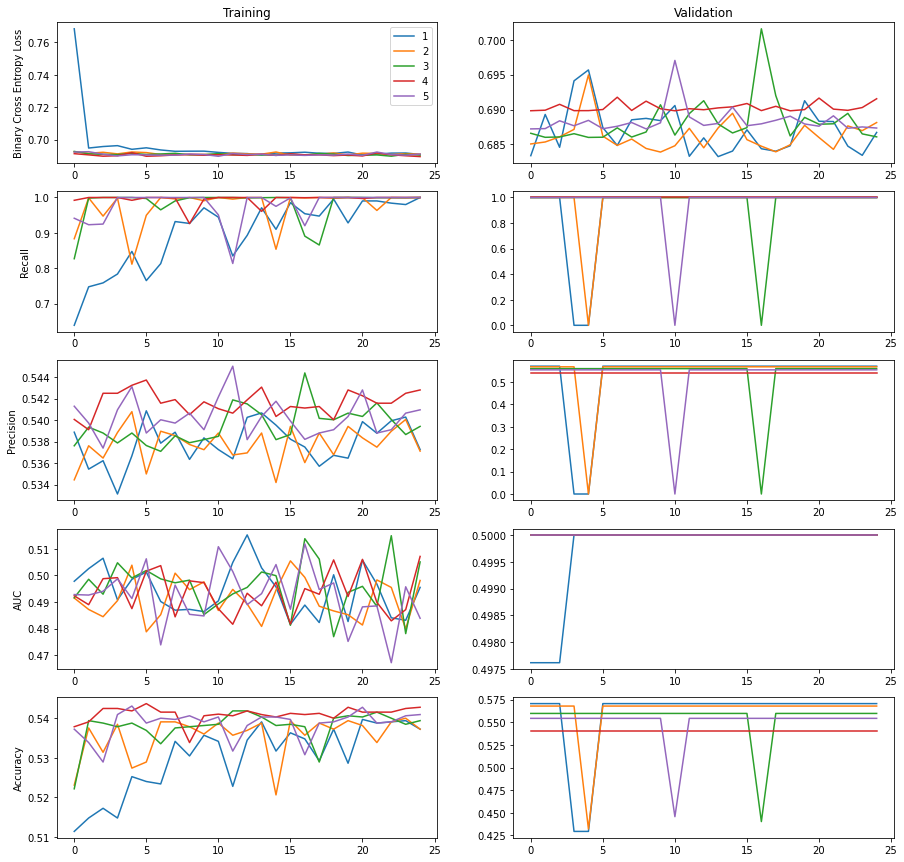

In [28]:
# plot metrics for first simple model
plot_metrics(base_model_scores)

Analysis: this is not surprising given that this model is supposed to represent a bad implementation of image classification.  This model actual has not a terrible F1 Score, but might be skewed because there may be more normal photos than tumor photos.  It is obvious that the model is only chosing one classification output.  I could reconfigure this model to have better classifications.  I believe the main issue happening with this model are vanishing gradients (hence why very little training appears to have happened).

### Simple Model 1
Model 1 is designed to be simple with as many same-value parameters.  This model has 2 convolutional layers, a max pooling layer, and 1 dense layer.  The idea of this model is to have a similar "base" like model to benchmark later models off of.  I did not design this model to solve our problems.

In [29]:
# define first model
def model1():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=32,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [30]:
# initialize empty list of scores
simple_model1_scores = []

cv_split = 1

# initialize model
simple_model1 = model1()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]

    # fit the model
    simple_model1_history = simple_model1.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    simple_model1_scores.append(simple_model1_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


In [31]:
# summarize model
simple_model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 180000)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                5760032   
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                      

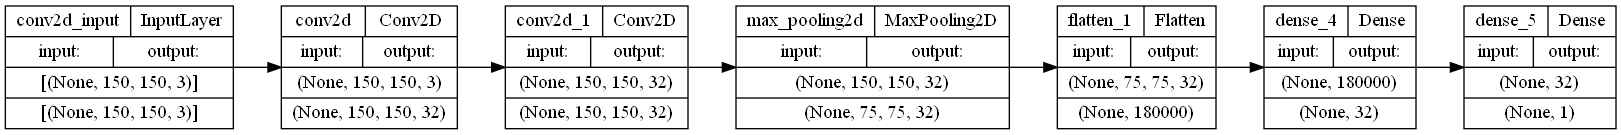

In [32]:
# plot model architecture
plot_model(
    simple_model1, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

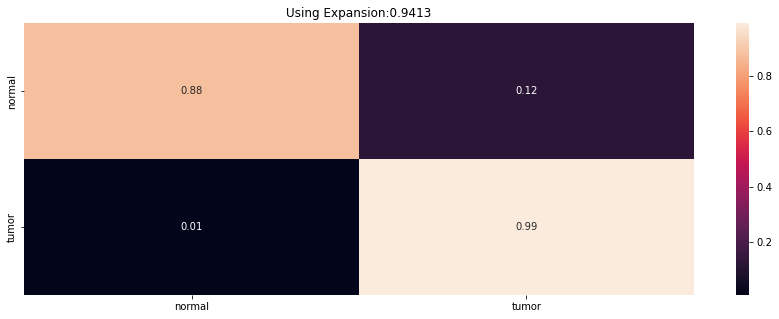

In [33]:
# summarize the last model to run
summarize_net(simple_model1, X_test, y_test, title_text='Using Expansion:')

In [34]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(simple_model1, X_test, y_test)

[[351  49]
 [  5 515]]
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       400
           1       0.91      0.99      0.95       520

    accuracy                           0.94       920
   macro avg       0.95      0.93      0.94       920
weighted avg       0.94      0.94      0.94       920



Model 1 Validation F1: 0.880431377295041
Model 2 Validation F1: 0.9031217511919076
Model 3 Validation F1: 0.9378026265799834
Model 4 Validation F1: 0.9566105522992074
Model 5 Validation F1: 0.9665362387626403
Average Model Validation F1 Score: 0.928900509225756


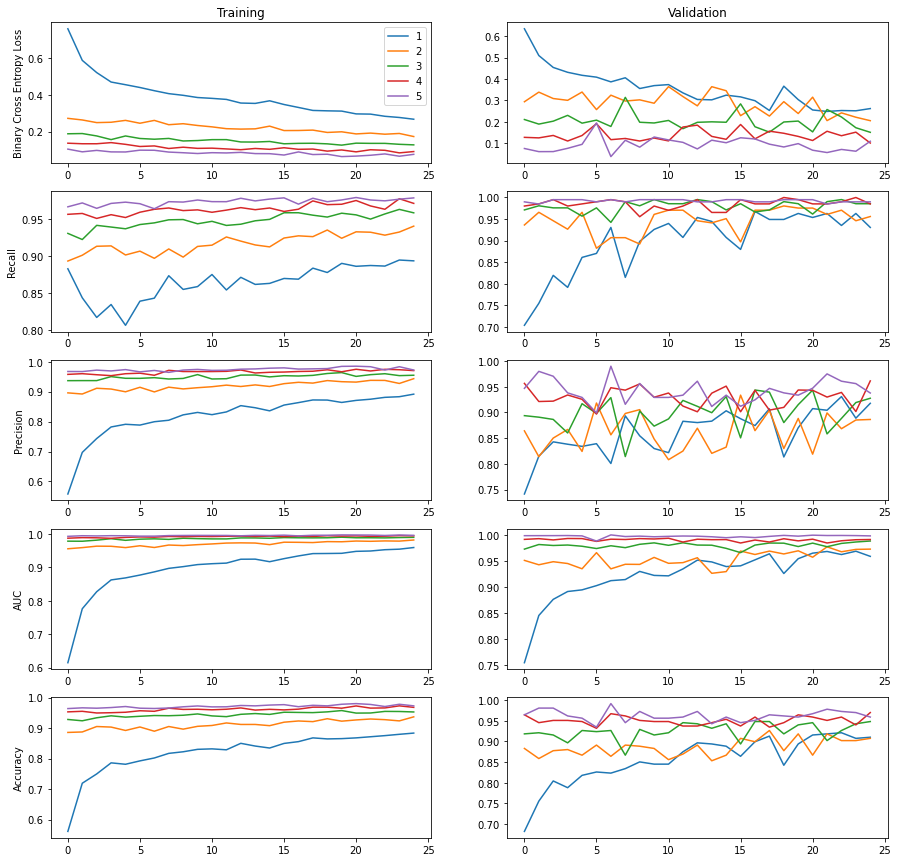

In [35]:
# plot metrics for first simple model
plot_metrics(simple_model1_scores)

Analysis: Much better F1 Scores than our base model, but overall a model that leaves a lot to be desired.  This makes sense.  I think I set this model up to not have enough layers to recognize discernable patterns for the last 4-5% of examples we missed.  But, the purpose of this model is to provide another benchmark for later model iterations - and to also showcase that simple models for this exercise may not provide the answers we seek for the accuracy and F1 scores we seek (near 100%)

### Simple Model 2
Changes made:
    
    - Changed filters for both CNNs to 64
    - Changed padding to "valid"
    - Changed 2nd Conv2D Layer to have an activation of tanh
    - Changed number of neurons in first Dense layer to 128

In [36]:
# define second model
def model2():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=64,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='valid', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='valid', 
                    activation="tanh", kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [37]:
# initialize empty list of scores
simple_model2_scores = []

cv_split = 1

# initialize model
simple_model2 = model2()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]


    
    # fit the model
    simple_model2_history = simple_model2.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    simple_model2_scores.append(simple_model2_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


In [38]:
# summarize model
simple_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 341056)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               43655296  
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

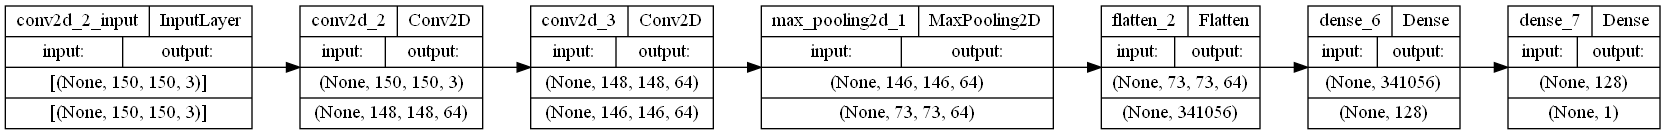

In [39]:
# plot model architecture
plot_model(
    simple_model2, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

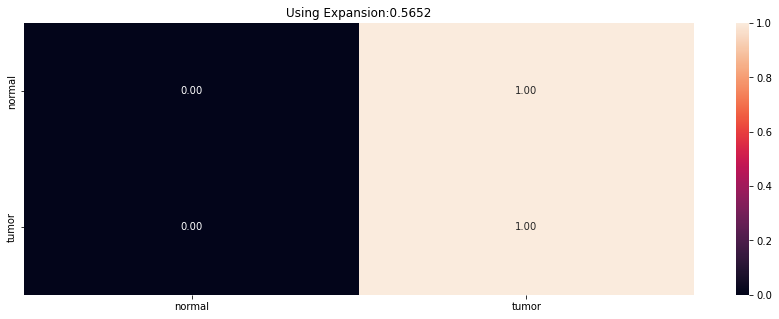

In [40]:
# summarize the last model to run
summarize_net(simple_model2, X_test, y_test, title_text='Using Expansion:')

In [41]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(simple_model2, X_test, y_test)

[[  0 400]
 [  0 520]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.57      1.00      0.72       520

    accuracy                           0.57       920
   macro avg       0.28      0.50      0.36       920
weighted avg       0.32      0.57      0.41       920



C:\Users\EV-04\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\EV-04\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\EV-04\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model 1 Validation F1: 0.7019400396399522
Model 2 Validation F1: 0.6330054533026079
Model 3 Validation F1: 0.6650088873722174
Model 4 Validation F1: 0.6446209627784449
Model 5 Validation F1: 0.6847552344578566
Average Model Validation F1 Score: 0.6658661155102159


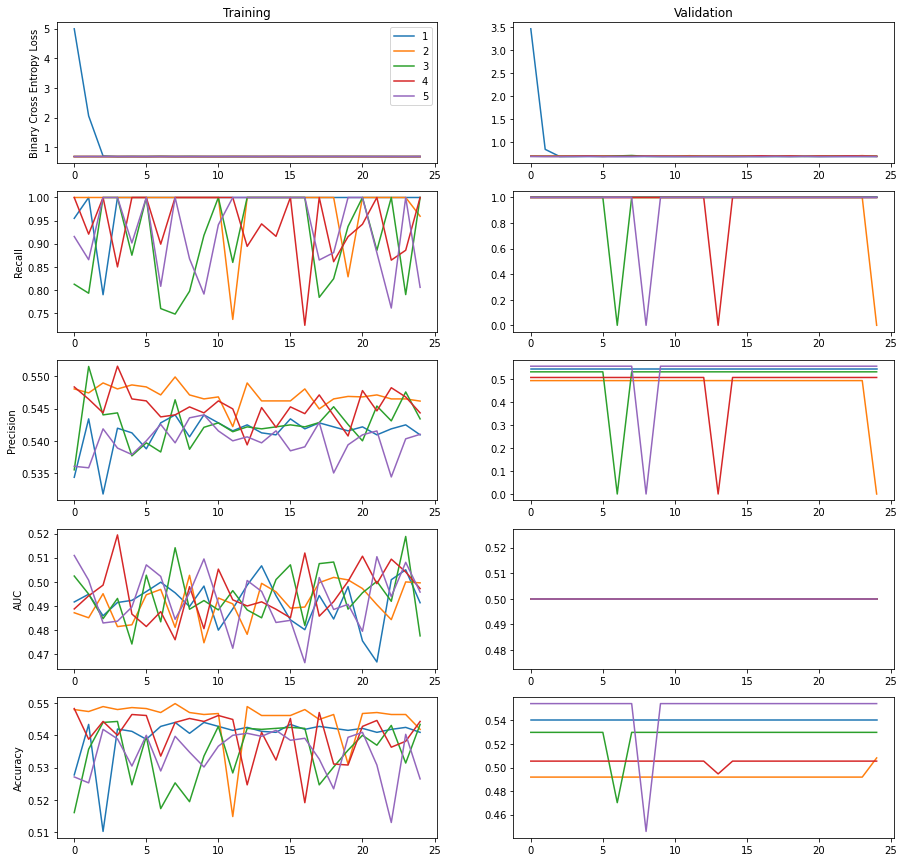

In [42]:
# plot metrics for first simple model
plot_metrics(simple_model2_scores)

Analysis: I'm surprised by bad performances overall because this is supposed to be a derivation of the first simple model - which performed well.  I believe I had configured my model with too many neurons and not the correct activation functions.  This model looks eerily similar to the base model which leads me to believe that perhaps this model is experiencing vanishing gradients.

### Complex Model 1
Complex Model 1 is to replicate the Simple Model 2 but with some more additions.  Additions include:

    - Added a 3rd Conv2D layer
    - Added a 4th Conv2D layers
    - Added a 2nd MaxPooling2D layer after the 4th Conv2D layer
    - Added Dropout of 20% before flattening
    - Added Dropout of 20% after the first Dense layer
    - Added a 2nd Dense layer
    - Added Dropout of 10% after the 2nd Dense layer
    - Added a 3rd Dense layer
    - Added Dropout of 5% after the 3rd Dense layer
    
The hypothesis is to create more layers that can identify more features within each MRI scan, hence the increase in number of convolutional layers as well as an increase in dense layers (to help with feature recognition).  This model is meant to be a model in which we can use in production.

In [43]:
# define second model
def model3():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=64,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add third convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add dropout
    cnn.add(Dropout(0.2))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.2))
    
    # add second dense layer
    cnn.add(Dense(64, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.1))
    
    # add third dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.05))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [44]:
# initialize empty list of scores
complex_model1_scores = []

cv_split = 1

# initialize model
complex_model1 = model3()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
   
    # fit the model
    complex_model1_history = complex_model1.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    complex_model1_scores.append(complex_model1_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


In [45]:
# summarize model
complex_model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

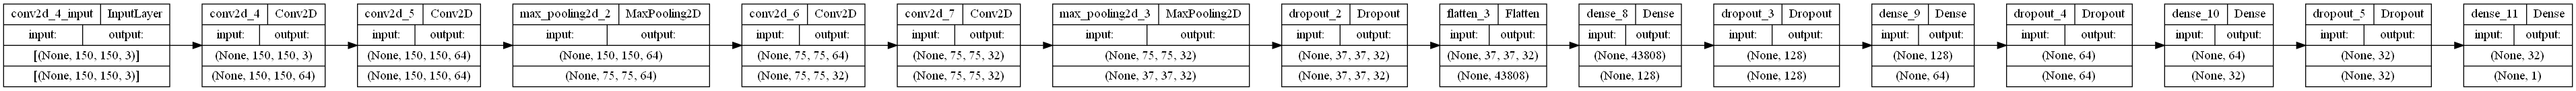

In [46]:
# plot model architecture
plot_model(
    complex_model1, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

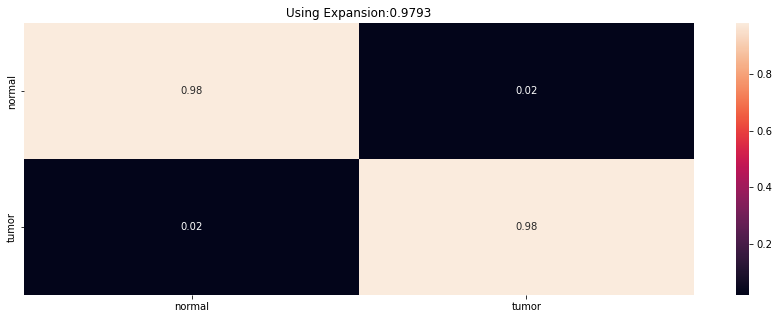

In [47]:
# summarize the last model to run
summarize_net(complex_model1, X_test, y_test, title_text='Using Expansion:')

In [48]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(complex_model1, X_test, y_test)

[[391   9]
 [ 10 510]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.98      0.98      0.98       520

    accuracy                           0.98       920
   macro avg       0.98      0.98      0.98       920
weighted avg       0.98      0.98      0.98       920



Model 1 Validation F1: 0.8366506494976084
Model 2 Validation F1: 0.9511236019283877
Model 3 Validation F1: 0.9754002604137
Model 4 Validation F1: 0.9849353121317787
Model 5 Validation F1: 0.9866715656178736
Average Model Validation F1 Score: 0.9469562779178696


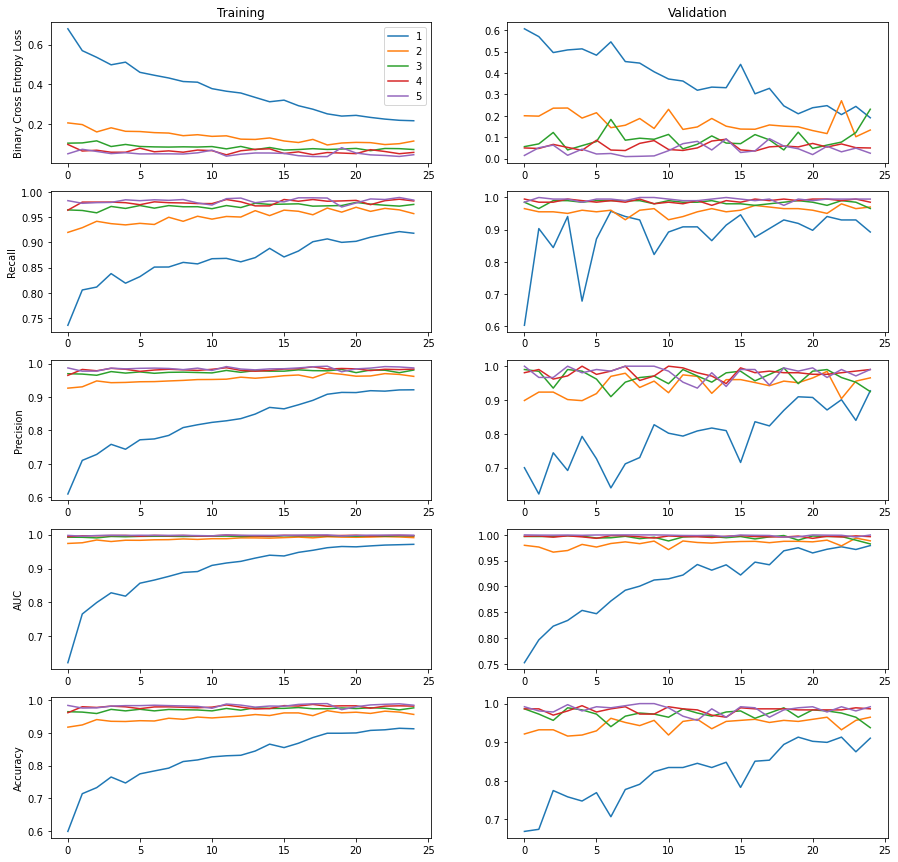

In [49]:
# plot metrics for first simple model
plot_metrics(complex_model1_scores)

Analysis:  This is more in line with what I had envisioned a workable model would look like and perform.  With a F1 Score of almost 0.99, I think this model is well on it's way to becoming a usable model for our purposes.  With only 19 total misdiagnosis guesses, I think this model can be used in production so long as it's used alongside a Doctor's discretion.  This model can not stand alone as a sole predictor for tumors vs non-tumor MRI scans.

### Complex Model 2
Changes include:

    - Reducing the 1st Conv2D layer filters from 64 to 32
    - Reducing the 2nd Conv2D layer filters from 64 to 32
    - Switching the 2nd Conv2D layer activation function from relu to tanh
    - Reducing the 3rd Conv2D layer filters from 32 to 16
    - Reducing the 4th Conv2D layer filters from 32 to 16
    - Switching the 4th Conv2D layer activation function from relu to tanh
    - Increasing the 1st Dropout from 20% to 50%
    - Increasing the 2nd Dropout from 20% to 25%
    - Increasing the 3rd Dropout from 10% to 20%
    - Increasing the 4th Dropout from 5% to 20%
    - Setting all dense layers to 32 neurons (128, 64, and 32 were the respective priors)
    
My idea behind this model is to decrease the total number of trainable parameters to make the model "simpler".  I believe in the majority of use cases, simpler is better.  This was the aim of this fourth model.  In the context of a tumor, I believe this is intuitive.  A tumor has only so many features about it.  Most tumors are round in shape.  The model is trying to identify an "out of place" round object.  In my opinion, this model does not need millions of parameters to identify odd looking edges, therefore I justify my reason to decrease my model trainable parameters with this logic.

In [50]:
# define second model
def model4():
    
    # initialize a convolutional neural network
    cnn = Sequential()

    # add first convolutional layer
    cnn.add(Conv2D(filters=32,
                    input_shape=input_shape,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation="tanh", kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add third convolutional layer
    cnn.add(Conv2D(filters=16,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation=conv_layer_activation, kernel_initializer=kernel_initializer))

    # add second convolutional layer
    cnn.add(Conv2D(filters=16,
                    kernel_size=(3,3), 
                    padding='same', 
                    activation="tanh", kernel_initializer=kernel_initializer))

    # add first max pooling
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add dropout
    cnn.add(Dropout(0.5))

    # flatten output
    cnn.add(Flatten())
    
    # add first dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.25))
    
    # add second dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.2))
    
    # add third dense layer
    cnn.add(Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer))
    
    # add dropout
    cnn.add(Dropout(0.2))
    
    # add output layer
    cnn.add(Dense(1, activation=final_activation))

    # Let's train the model 
    cnn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return cnn

In [51]:
# initialize empty list of scores
complex_model2_scores = []

cv_split = 1

# initialize model
complex_model2 = model4()

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
   
    # fit the model
    complex_model2_history = complex_model2.fit(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train_cv)/batch_size), epochs=epochs, verbose=0, 
                            validation_data=(X_test_cv,y_test_cv))
    
    # append scores
    complex_model2_scores.append(complex_model2_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


In [52]:
# summarize model
complex_model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 75, 75, 16)        4624      
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                  

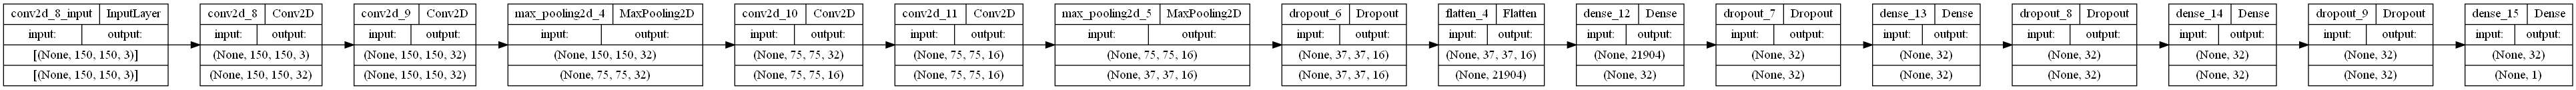

In [53]:
# plot model architecture
plot_model(
    complex_model2, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

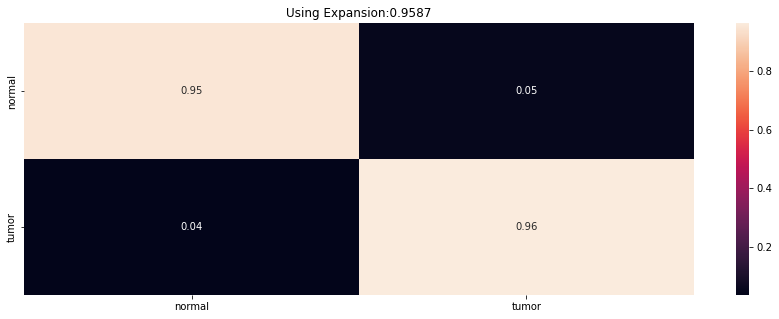

In [54]:
# summarize the last model to run
summarize_net(complex_model2, X_test, y_test, title_text='Using Expansion:')

In [55]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(complex_model2, X_test, y_test)

[[381  19]
 [ 19 501]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       400
           1       0.96      0.96      0.96       520

    accuracy                           0.96       920
   macro avg       0.96      0.96      0.96       920
weighted avg       0.96      0.96      0.96       920



Model 1 Validation F1: 0.8469714774090829
Model 2 Validation F1: 0.9385984178775572
Model 3 Validation F1: 0.9547023645015825
Model 4 Validation F1: 0.9674142224744732
Model 5 Validation F1: 0.9656587964515642
Average Model Validation F1 Score: 0.934669055742852


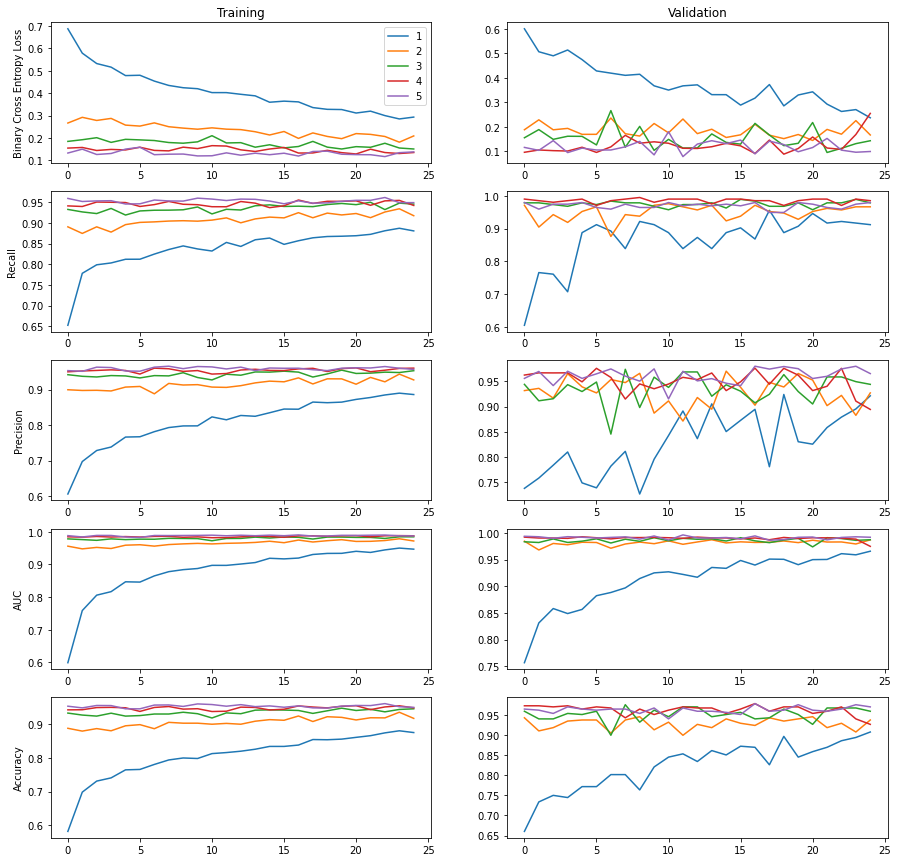

In [56]:
# plot metrics for first simple model
plot_metrics(complex_model2_scores)

Analysis:  Decent model, but although my expectations were subverted and my hypothesis on simpler is better was wrong it appears.  Still better F1 Scores than most previous models, but complex model 1 is still my best model.  I think it would be a better comparison if I ran both models over a large number of epochs and maybe with more cv splits.  However, after seeing all models perform, it's safe to say complex model 1 is my best model.

### Model Comparisions

> [1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.

In this section we go over model comparisons.  Analysis will be provided at the end of this section.  In this section we compare F1 Scores, AUC, and look at the McNemar test to assess whether each model is statistically different.

In [57]:
# get the F1 Scores for each model
simple_model1_f1 = f1_score_calc(precision=simple_model1_scores[4]["val_precision"], recall=simple_model1_scores[4]["val_recall"])
simple_model2_f1 = f1_score_calc(precision=simple_model2_scores[4]["val_precision"], recall=simple_model2_scores[4]["val_recall"])
complex_model1_f1 = f1_score_calc(precision=complex_model1_scores[4]["val_precision"], recall=complex_model1_scores[4]["val_recall"])
complex_model2_f1 = f1_score_calc(precision=complex_model2_scores[4]["val_precision"], recall=complex_model2_scores[4]["val_recall"])

C:\Users\EV-04\AppData\Local\Temp/ipykernel_18720/2133172958.py:2: RuntimeWarning: invalid value encountered in true_divide
  return 2 * np.multiply(precision, recall)/np.add(precision, recall)


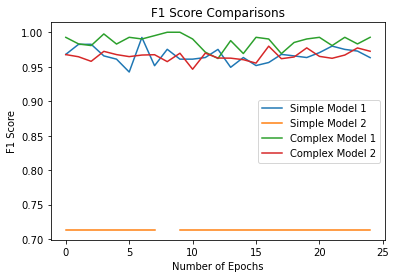

In [58]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(simple_model1_f1)
plt.plot(simple_model2_f1)
plt.plot(complex_model1_f1)
plt.plot(complex_model2_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Simple Model 1", "Simple Model 2", "Complex Model 1", "Complex Model 2"])

In [59]:
# get the average AUC for all models
simple_model1_auc = avg_metric(scores=simple_model1_scores, metric="val_auc")
simple_model2_auc = avg_metric(scores=simple_model2_scores, metric="val_auc")
complex_model1_auc = avg_metric(scores=complex_model1_scores, metric="val_auc")
complex_model2_auc = avg_metric(scores=complex_model2_scores, metric="val_auc")

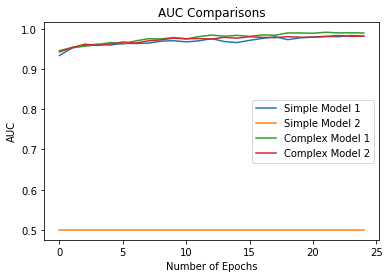

In [60]:
# plot out all model AUC
plt.title('AUC Comparisons')
plt.plot(simple_model1_auc)
plt.plot(simple_model2_auc)
plt.plot(complex_model1_auc)
plt.plot(complex_model2_auc)
plt.ylabel('AUC')
plt.xlabel('Number of Epochs')
plt.legend(["Simple Model 1", "Simple Model 2", "Complex Model 1", "Complex Model 2"])

In [61]:
# mcnemar test between models
simple_model1_accuracy = avg_metric(scores=simple_model1_scores, metric="val_Accuracy")
simple_model2_accuracy = avg_metric(scores=simple_model2_scores, metric="val_Accuracy")
complex_model1_accuracy = avg_metric(scores=complex_model1_scores, metric="val_Accuracy")
complex_model2_accuracy = avg_metric(scores=complex_model2_scores, metric="val_Accuracy")

mcnemar_test(simple_model1_accuracy, simple_model2_accuracy)
mcnemar_test(simple_model1_accuracy, complex_model1_accuracy)
mcnemar_test(simple_model1_accuracy, complex_model2_accuracy)
mcnemar_test(simple_model2_accuracy, complex_model1_accuracy)
mcnemar_test(simple_model2_accuracy, complex_model2_accuracy)
mcnemar_test(complex_model1_accuracy, complex_model2_accuracy)

0.08369565296173097 0.08369565296173097
0.08369565296173097 0.08369565296173097
0.08369565296173097 0.08369565296173097
0.47684782290458677 0.47684782290458677
0.47684782290458677 0.47684782290458677
0.0590652174949646 0.0590652174949646


(0.0590652174949646, 0.0590652174949646)

Analysis: Nearly all models had similar F1 scores and AUC comparisons (except simple model 2).  All models are not statistically different from one another meaning that all models are training and trying to generalize on the same features (per the McNemar test).  complex model 1 is still my best model in terms of F1 score and I will be using this as a comparison against the base model and the transfer learning model

### Base Model vs Best Model

> [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.

In this section we compare what our MLP model looks like compared to our best performing model above.  Similar to the above section, final analysis will be provided at the end of this section.  We look to compare F1 Scores, AUC, and perform a statistical significance test via McNemar.  Additionally, we look to compare the true positive vs false positives for each model.

**Our best model is determined by the highest F1 Score in the last CV split for each model run**

In [62]:
# calculate base model statistics
base_model_f1 = f1_score_calc(precision=base_model_scores[4]["val_precision"], recall=base_model_scores[4]["val_recall"])
base_model_auc = avg_metric(scores=base_model_scores, metric="val_auc")
base_model_accuracy = avg_metric(scores=base_model_scores, metric="val_Accuracy")

C:\Users\EV-04\AppData\Local\Temp/ipykernel_18720/2133172958.py:2: RuntimeWarning: invalid value encountered in true_divide
  return 2 * np.multiply(precision, recall)/np.add(precision, recall)


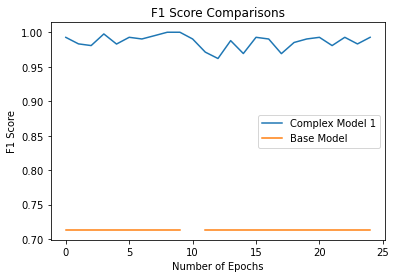

In [103]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(complex_model1_f1)
plt.plot(base_model_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Complex Model 1", "Base Model"])

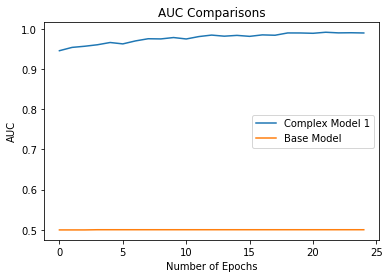

In [104]:
# plot out all model AUC
plt.title('AUC Comparisons')
plt.plot(complex_model1_auc)
plt.plot(base_model_auc)
plt.ylabel('AUC')
plt.xlabel('Number of Epochs')
plt.legend(["Complex Model 1", "Base Model"])

In [105]:
# calculate the TP, FP, and ROC
base_model_fp, base_model_tp, base_model_roc = roc_calc(base_model, X_test, y_test)
complex_model1_fp, complex_model1_tp, complex_model1_roc = roc_calc(complex_model1, X_test, y_test)

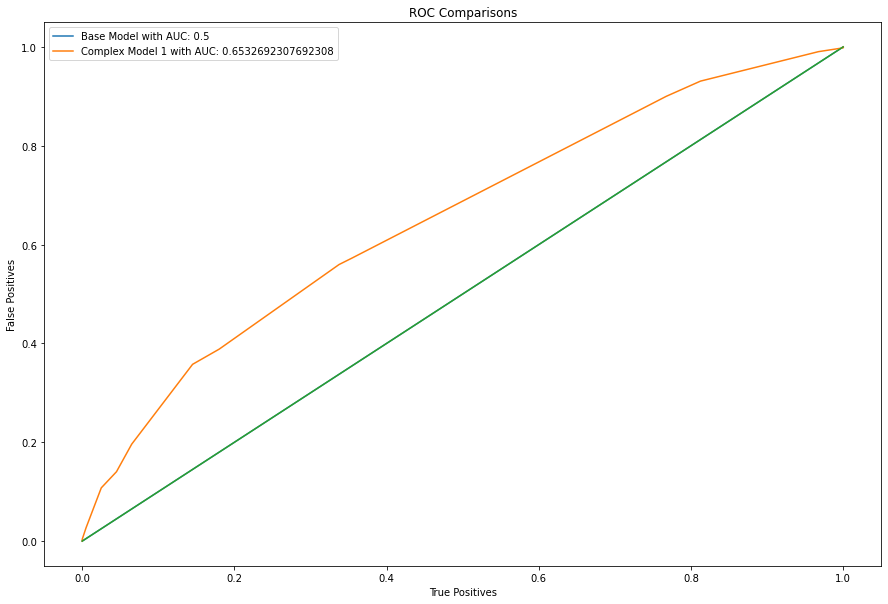

In [107]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(base_model_fp, base_model_tp)
plt.plot(complex_model1_fp, complex_model1_tp)
plt.plot([0, 1])
plt.ylabel('False Positives')
plt.xlabel('True Positives')
plt.legend([f"Base Model with AUC: {base_model_roc}", f"Complex Model 1 with AUC: {complex_model1_roc}"])

In [67]:
# perform statistical significance test
mcnemar_test(complex_model1_accuracy, base_model_accuracy)

0.0590652174949646 0.0590652174949646


(0.0590652174949646, 0.0590652174949646)

Analysis: The base model ROC and AUC is not great.  In fact, the Base model ROC is in line with the default line, meaning the model did not generalize to differentiate between a tumor and a non-tumor MRI scan.  However, the complex model 1 ROC is also not ideal.  This means that even though we split the data and used validation sets for our analysis, when faced with the true X and y test sets, it fails to what we want to achieve and that there may be a lot of overfitting.

In terms of signficance, neither model is statistically different as both are generalizing using the same features (per the McNemar test).

### Exceptional Work

> One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 

In this section, I use the Xception network with Imagenet weights.  There is no reason why, it's arbitrary.  But I do predict that highly sophisticated networks such as Xception can still perform just as well, if not better than my models.  These models are designed to generalize and identify features.  I believe these features and features that define what a tumor looks like are similar.  Therefore, I am confident to predict that this model will perform just as well if not better than my models.  Like all other sections, final analysis will be provided at the end

In [70]:
# initialize Xception model with imagenet weights
xcep_no_top = Xception(weights='imagenet', include_top=False)

x_train_up = preprocess_input(X_train)
x_test_up = preprocess_input(X_test)

In [73]:
# train on half the data, to save a few hours
X_train_resnet = xcep_no_top.predict(X_train)
X_test_resnet = xcep_no_top.predict(X_test)
print(X_train_resnet.shape)

(3680, 5, 5, 2048)


In [75]:
input_x = Input(shape=X_train_resnet[0].shape)

# add first max pooling
pool1 = MaxPooling2D(pool_size=(2, 2))(input_x)

# add dropout
drop1 = Dropout(0.2)(pool1)

# flatten output
flat = Flatten()(drop1)

# add first dense layer
dense1 = Dense(128, activation=dense_layer_activation, kernel_initializer=kernel_initializer)(flat)

# add dropout
drop2 = Dropout(0.2)(dense1)

# add second dense layer
dense2 = Dense(64, activation=dense_layer_activation, kernel_initializer=kernel_initializer)(drop2)

# add dropout
drop3 = Dropout(0.1)(dense2)

# add third dense layer
dense3 = Dense(32, activation=dense_layer_activation, kernel_initializer=kernel_initializer)(drop3)

# add dropout
drop4 = Dropout(0.05)(dense3)

# add output layer
predictions = Dense(1, activation=final_activation)(drop4)

transfer_model = Model(inputs=input_x, outputs=predictions)
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 2048)]      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 2048)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 2, 2, 2048)        0         
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                             

In [80]:
# initialize empty list of scores
transfer_model_scores = []

cv_split = 1

# initialize model
# complex_model2 = model4()
transfer_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train, y_train):
    
    print(f"On Split {cv_split}")
    
    x_train_cv = X_train_resnet[train_index]
    y_train_cv = y_train[train_index]
    x_test_cv = X_train_resnet[test_index]
    y_test_cv = y_train[test_index]
   
    # fit the model
    transfer_model_history = transfer_model.fit(x_train_cv,y_train_cv,epochs=epochs, batch_size=batch_size, verbose=False, validation_data=(x_test_cv, y_test_cv))
    
    # append scores
    transfer_model_scores.append(transfer_model_history.history)
    
    cv_split += 1

On Split 1
On Split 2
On Split 3
On Split 4
On Split 5


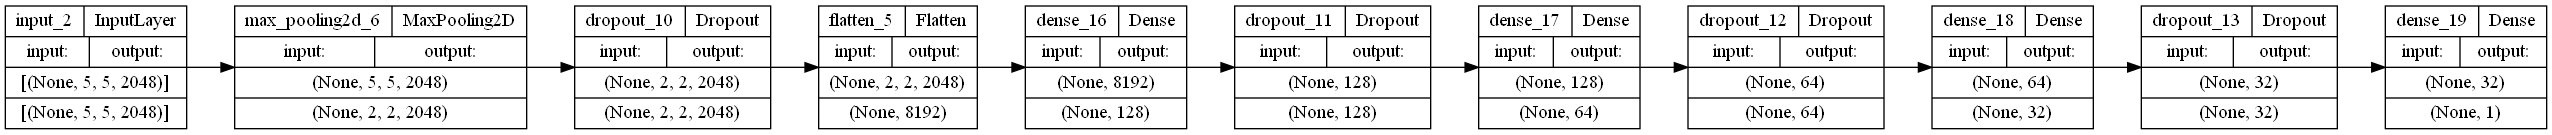

In [82]:
# plot model architecture
plot_model(
    transfer_model, show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

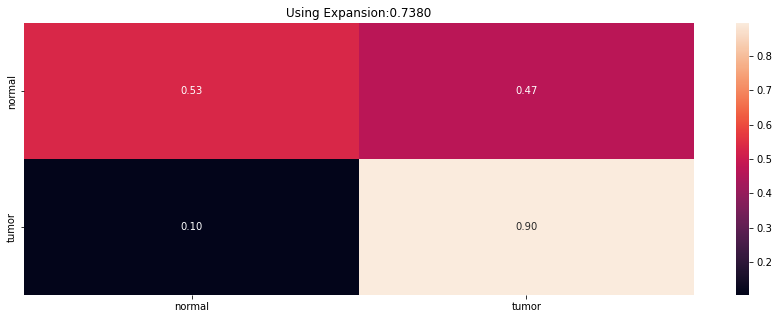

In [84]:
# summarize the last model to run
summarize_net(transfer_model, X_test_resnet, y_test, title_text='Using Expansion:')

In [86]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(transfer_model, X_test_resnet, y_test)

[[213 187]
 [ 54 466]]
              precision    recall  f1-score   support

           0       0.80      0.53      0.64       400
           1       0.71      0.90      0.79       520

    accuracy                           0.74       920
   macro avg       0.76      0.71      0.72       920
weighted avg       0.75      0.74      0.73       920



Model 1 Validation F1: 0.7799744303627593
Model 2 Validation F1: 0.7343418491367742
Model 3 Validation F1: 0.773811400461344
Model 4 Validation F1: 0.7531606994015505
Model 5 Validation F1: 0.7339949015049089
Average Model Validation F1 Score: 0.7550566561734675


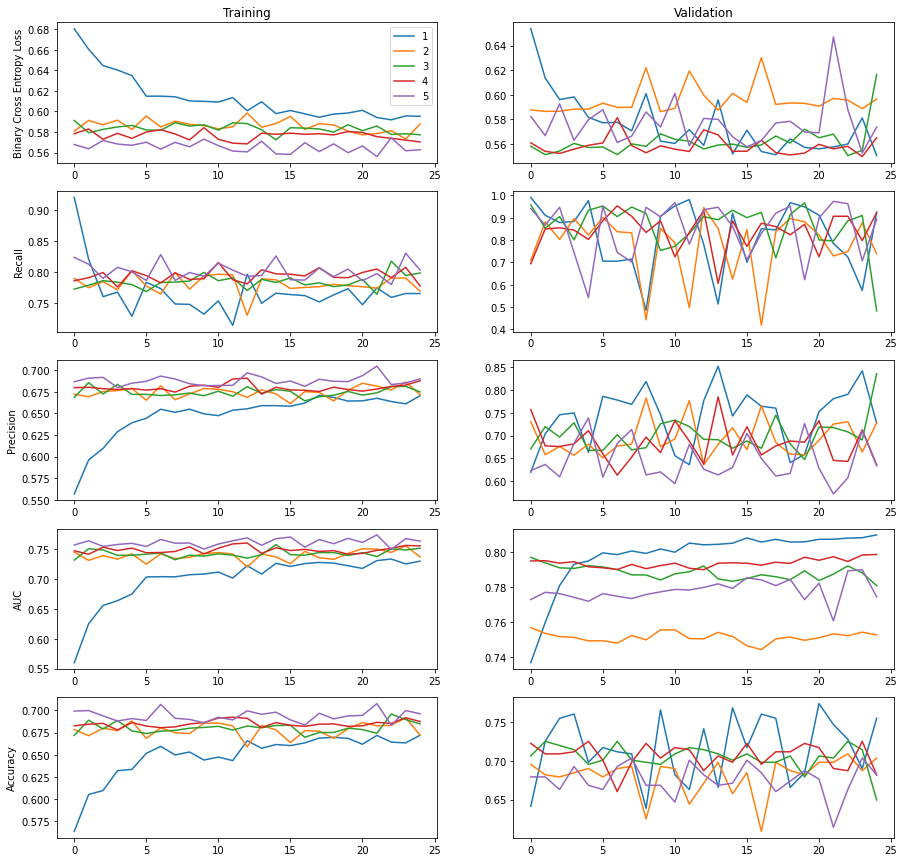

In [87]:
plot_metrics(transfer_model_scores)

In [88]:
transfer_model_f1 = f1_score_calc(precision=transfer_model_scores[4]["val_precision"], recall=transfer_model_scores[4]["val_recall"])
transfer_model_auc = avg_metric(scores=transfer_model_scores, metric="val_auc")
transfer_model_accuracy = avg_metric(scores=transfer_model_scores, metric="val_Accuracy")

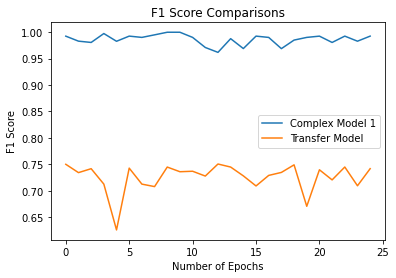

In [97]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(complex_model1_f1)
plt.plot(transfer_model_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Complex Model 1", "Transfer Model"])

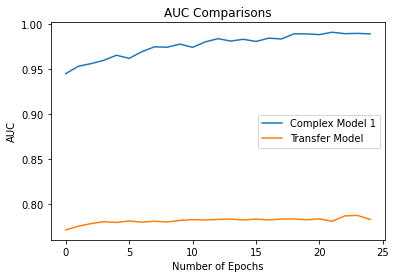

In [98]:
# plot out all model AUC
plt.title('AUC Comparisons')
plt.plot(complex_model1_auc)
plt.plot(transfer_model_auc)
plt.ylabel('AUC')
plt.xlabel('Number of Epochs')
plt.legend(["Complex Model 1", "Transfer Model"])

In [99]:
transfer_model_fp, transfer_model_tp, transfer_model_roc = roc_calc(transfer_model, X_test_resnet, y_test)
complex_model1_fp, complex_model1_tp, complex_model1_roc = roc_calc(complex_model1, X_test, y_test)

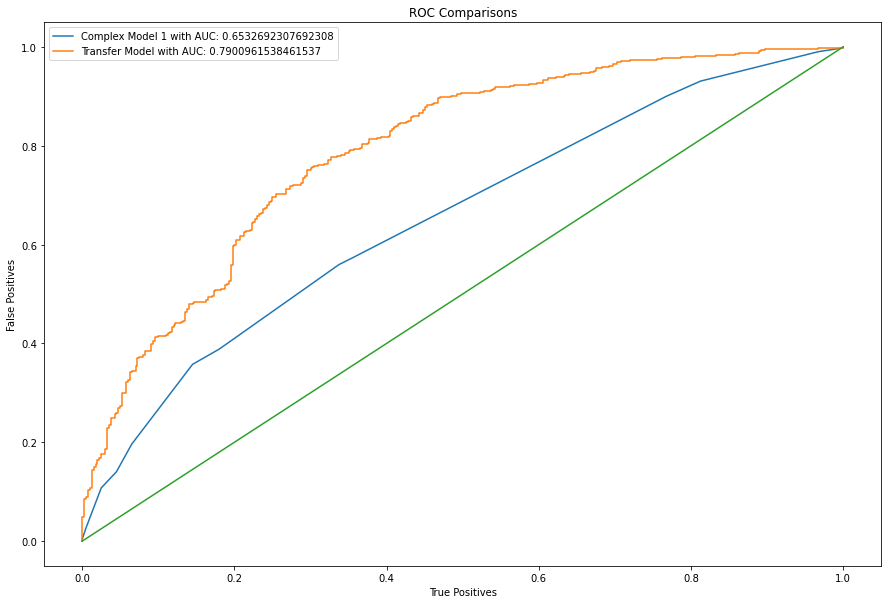

In [102]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(complex_model1_fp, complex_model1_tp)
plt.plot(transfer_model_fp, transfer_model_tp)
plt.plot([0, 1])
plt.ylabel('False Positives')
plt.xlabel('True Positives')
plt.legend([f"Complex Model 1 with AUC: {complex_model1_roc}", f"Transfer Model with AUC: {transfer_model_roc}"])

In [96]:
mcnemar_test(complex_model1_accuracy, transfer_model_accuracy)

0.0590652174949646 0.0590652174949646


(0.0590652174949646, 0.0590652174949646)

### Final Analysis

Although our complex model 1 had shown signs of promising F1 scores, it fails when comparing it against the pretrained model when using X and y test sets.  The pretrained model also subverted expectations.  I would have expected pretrained weights to be able to identify tumor features with more precision.  Compared to complex model 1, this may be true, but in a real life model scenario we would have to work this model more.

In terms of significance, neither model is different from each other.

If I were to run this again, I would try without normalizing the images or using a different type of normalization method (such as Robust or Standard).  Additionally, I truly believe there is a model that can be produced that can achieve high F1 scores on both the training and testing sets without overfitting.  I have ran this model several times with different random seeds and got different results - some in which the complex model 1 or 2 would have near perfect F1 scores on the test sets.  But I chose to leave this analysis in to showcase that there is much more nuance to this model than one would initially think.

Overall, my business recommendation is that complex model 1, 2, or transfer learning models are usable, but only with human (doctor) intelligence.